# Inteligencia Artificial Yeferson Nova

In [2]:
#1
#Importamos las carpetas del Google drive donde vamos a realizar el proyecto
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#2
#cambiamos la ruta de ejecucucion a la capeta creada para el proyecto -- remplezar el nombre de la caprta segun el caso
%cd /content/drive/MyDrive/EmocionesAI

/content/drive/MyDrive/EmocionesAI


In [ ]:
#unificacion de versiones de tensorflow

!pip install tensorflow==2.8.0
!pip install keras==2.3.0

In [ ]:
#3
#importamos las librerias que vamos a requerir para las tareas
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


In [ ]:
#4
#cargamos un dataset provisto por https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
#previamente debemos cargar en la carpeta del drive el archivo con nombre data.csv  https://drive.google.com/file/d/1p9mrXPPfcgE2MUmHW73w6DzP79jCf9Q7/view?usp=sharing
# pd.read_csv se utiliza para leer el archvio csv y keyfacial_df es una varable donde se guarnda los datos
keyfacial_df = pd.read_csv('/content/drive/MyDrive/EmocionesAI/data.csv')

In [ ]:
# imprimir em patalla el dataset que se cargo previamente
keyfacial_df
# Las columnas que se muestran luego de la carga representan los puntos de cada punto tanto pares como impares

In [ ]:
#5
# keyfacial_df.info() lo usamos con el fon de ver unicamente las columnas que tiene el data set
keyfacial_df.info()

In [ ]:
#6
# con la funcion isnull contamos los valores que no tengan datos luego con la agregación de sum determinamos la sumatoria de los valores que están nulos con fin de probar el dataset
keyfacial_df.isnull().sum()

In [ ]:
#7
# con esta funcion le pasamos la columna Image para saber el tamaño de nuestra imagen
keyfacial_df['Image'].shape

(2140,)

In [ ]:
#funcion lamda que transforma cada cadena separada por espacio en posiciones x y y transformamos esos datos para obtener un array bidimencional con imagenes de tamaño 96 x 96 pixeles

keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [ ]:
#visualizar el tamaño de la imagen en la posicion del vector 0
keyfacial_df['Image'][0].shape

(96, 96)

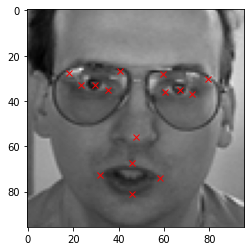

In [ ]:
#Prueba de verificación de los datos que están en la matriz usando i como una variable aleatoria para seleccionar la fila de matriz,
#usamos la función imshow para pintar los puntos descritos en esa fila del vector y cmap para usar escala de grises
i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
  #plt.plot lo usamos para pintar sibre la imagen
        plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

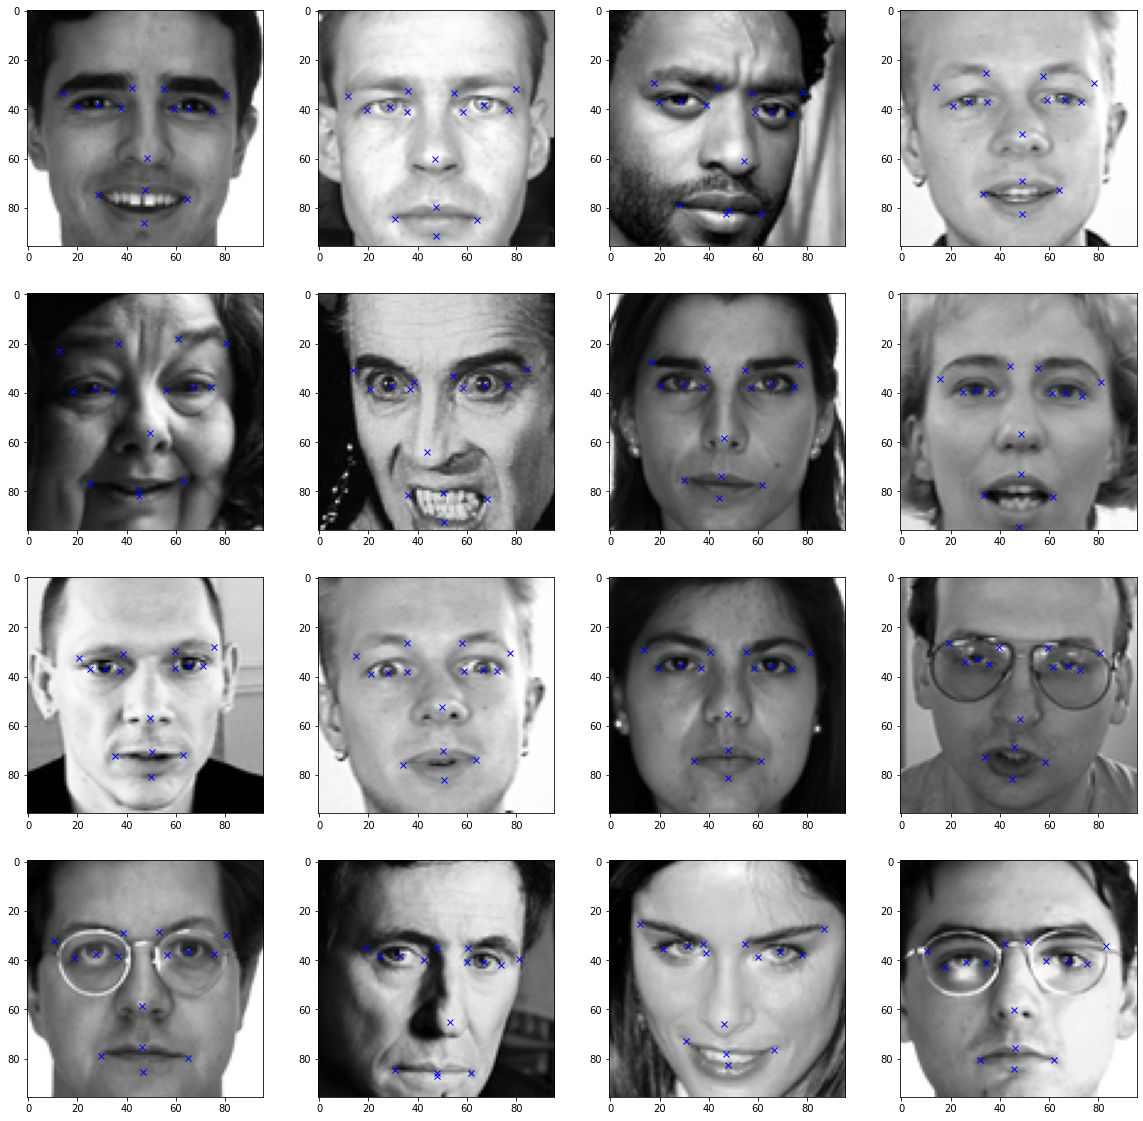

In [ ]:
#usamos la misma funcion anterior solo le agregamos un ciclo for de rango 16 para probar  con una matriz de matrices y se dibugen a modo de verificacion de puntos esten acorde a los puntos usando la funcion ramdom
#para cambiar los valores de la matriz a dibujar
#fig definimos una figura de tamaño 20 x20 en la cual va  estar la matriz de imagenes
import random

fig = plt.figure(figsize=(20, 20))

for i in range(16):
    k = random.randint(1, len(keyfacial_df))
    ax = fig.add_subplot(4, 4, i + 1)
    image = plt.imshow(keyfacial_df['Image'][k],cmap = 'gray')
    for j in range(1,31,2):
        plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'bx')

In [ ]:
#realizamos aumentacion del dataset con el fin de ampliar la gama de datos del modelo de la ai aumnetando el brillo, bajando brillo, girando imagenes
#para ahumentar  la cantidad de tipos de imagenes asi el modelo puede generalizar mas el dataset.

# Creamos una copia del dataset
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [ ]:
#obtener las columnas del dataset
columns = keyfacial_df_copy.columns[:-1]
columns

In [ ]:
# np.flip lo usamos para da la vuelta a las imágenes entorno al eje y
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

# como giramos la imagen horizontalmente, los valores de la coordenada y serían los mismos
# solo necesitamos cambiar los valores de la coordenada x, para esto restamos los valores iniciales de la coordenada x del ancho de la imagen (96) ejemplo la posición  0 pasa a ser la posicion 96 la 1 la 95 asi sucesivamente
for i in range(len(columns)):
  if i%2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x) )

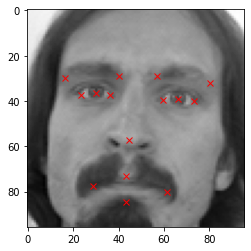

In [ ]:
# para comprobar que funciono el giro de las imagenes imprimimos la imagen original
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df.loc[0][j-1], keyfacial_df.loc[0][j], 'rx')

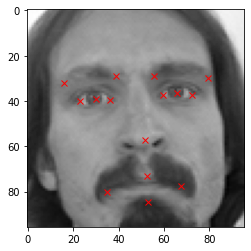

In [ ]:
# mostramos la imagen que se giro horizaontalmente

plt.imshow(keyfacial_df_copy['Image'][0],cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

de esta manera tenemos el doble de datos y imagenes en nuestro dataset asi vamos variando el conjunto de datos y mejorar la acertividad en modo produccion

In [ ]:
#ahora vamos a concatenar ambos datset el keyfacial_df y keyfacial_df_copy, recodemos en paso 37 tenemos 2140 filas de nuestro daset original
#ahora nuestra cariable que tiene el daset completo es augmented_df
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

In [ ]:
#imprimimos la cantidad de regitros de nuestro datset pára cmprobar la union
augmented_df.shape

(4280, 31)

In [ ]:
#como ya duplicamos la cantidad de datos de nuestro dataset original ahora podemos variar las imagenes en funcion del brillo o contraste
#asi diversificamos las imagenes preparando nuestro modelo para datos con imagenes que se tomen de noche de dia o en uan gama de condiciones variadas

# Multiplicamos los valores de los píxeles por valores aleatorios entre 1,5 y 2 para aumentar el brillo de la imagen
# Recortamos el valor entre 0 y 255

import random

keyfacial_df_copy = copy.copy(keyfacial_df)
#funcion que multiploca el pixel para aumentar el brillo sin embargo valida si el pixel este dentro del rango optimo del brillo 255
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(1.5, 2)* x, 0.0, 255.0))
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

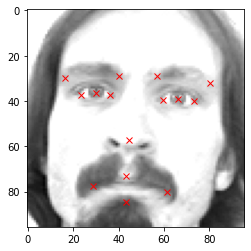

In [ ]:
# imprimimos la imagen con brillo aumentado
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
        plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

A partir de este momento ya tenemos el dataset con variedad de datos y con suficiente cantidad procedemos a normalizar los datos para prepararlos para el modelo de entrenamiento o de test.

In [ ]:
#vamos a crear una variable img con todas las imgenes de nuestro dataset
img = augmented_df[:,30]
#cada imagen tiene  valores desde 0 a 255
img = img/255.
# creamos un array vacío de tamaño (x, 96, 96, 1) para subministrar al modelo
X = np.empty((len(img), 96, 96, 1))

#iteramos sobre la lista de imágenes y añadimos uan dimension de (96, 96) a (96, 96, 1)
for i in range(len(img)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# ahora convertimos el tipo array a float32 esta esta estructura e spor requerimiento de tensorflow
X = np.asarray(X).astype(np.float32)
X.shape

(6420, 96, 96, 1)

In [ ]:
# dividimos los datos entre entrenamiento y testing   usando el 20% para test y 80% para entrenamiento
y = augmented_df[:,:30]
y = np.asarray(y).astype(np.float32)
y.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
#verificamos el tamaño de entrenamiento
X_train.shape

(5136, 96, 96, 1)

In [ ]:
#verificamos el tamaño de dataset de test
X_test.shape

(1284, 96, 96, 1)

A partir de este momento ya podemos crear la primera red neuronal residual  y usar lo bloques residuales

In [ ]:
def res_block(X, filter, stage):

  # bloque convolucional
  X_copy = X

  f1 , f2, f3 = filter

  # camino principal
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # camino corto
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # añadir
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # bloque de identidad 1
  X_copy = X


  # camino principal
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # añadir
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # bloque de identidad 2
  X_copy = X


  # camino Principal
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # añadir
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
input_shape = (96, 96, 1)

# Tamaño del tensor de entrada
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - Fase
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - Fase
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - Fase
X = res_block(X, filter= [128,128,512], stage= 3)

# 4 - Fase
#X = res_block(X, filter= [256,256,1024], stage= 4)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Capa Final
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(30, activation = 'relu')(X)


model_1_facialKeyPoints = Model( inputs= X_input, outputs = X)
model_1_facialKeyPoints.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________